<a href="https://colab.research.google.com/github/yanamushka/ML_portfolio/blob/main/Quira_questions_duplicates2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy==1.26.0

[Exploratory Data Analysis](#exploratory-data-analysis)
[Text Preprocessing](#text-preprocessing)
[Modeling](#modeling)
[Bert Embeddings](#bert-embeddings)
[Bert Tuning](#bert-tuning)
[Text Preparing](#text-preparing)
[Results](#results)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df_train = pd.read_csv('/content/quora_question_pairs_train.csv.zip', index_col = 0)
df_test = pd.read_csv('/content/quora_question_pairs_test.csv.zip', index_col = 0)
pd.set_option('display.max_columns', None)
df_train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1


# 1. Exploratory Data Analysis

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323432 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323432 non-null  int64 
 1   qid2          323432 non-null  int64 
 2   question1     323431 non-null  object
 3   question2     323430 non-null  object
 4   is_duplicate  323432 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


In [ ]:
df_train[df_train['question2'].isnull()]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
201841,303951,174364,How can I create an Android app?,NaN,0
105780,174363,174364,How can I develop android app?,NaN,0


In [ ]:
df_train[df_train['question1'].isnull()]

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


The dataste consists of 5 columns and 323432 rows. Columns with questioins have missing values, but it's under 1%, so we can remove these rows from the dataset.

In [ ]:
df_train = df_train.dropna()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323429 entries, 332278 to 402019
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          323429 non-null  int64 
 1   qid2          323429 non-null  int64 
 2   question1     323429 non-null  object
 3   question2     323429 non-null  object
 4   is_duplicate  323429 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 14.8+ MB


The target column is_duplicate. Let's check the proportion of the positive class to negative

In [ ]:
print(f'Positive class: {df_train.is_duplicate.value_counts(normalize = True).mul(100).round(2)[1]}%')
print(f'Negative class: {df_train.is_duplicate.value_counts(normalize = True).mul(100).round(2)[0]}%')

Positive class: 36.92%
Negative class: 63.08%


In [ ]:
df_train['q1_len'] = df_train['question1'].astype(str).apply(lambda x: len(x.split()))
df_train['q2_len'] = df_train['question2'].astype(str).apply(lambda x: len(x.split()))

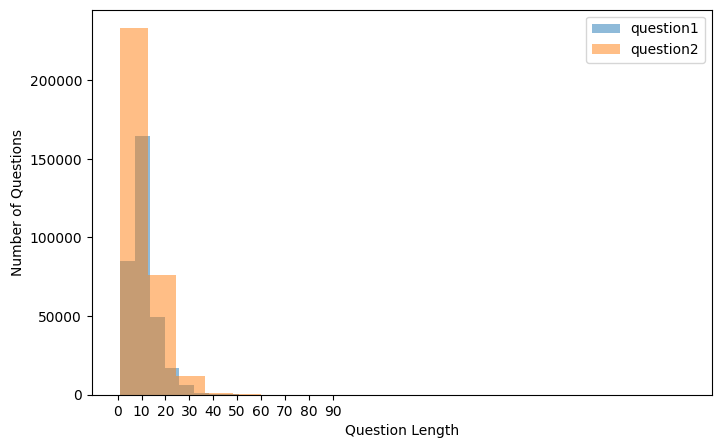

In [ ]:
plt.figure(figsize = (8, 5))
plt.hist(df_train['q1_len'], bins = 20, alpha = 0.5, label = 'question1')
plt.hist(df_train['q2_len'], bins = 20, alpha = 0.5, label = 'question2')
plt.xlabel('Question Length')
plt.ylabel('Number of Questions')
plt.xticks(np.arange(0,100,10))
plt.legend()

For both of the question columns the most popular question lengths is up to 10 words.

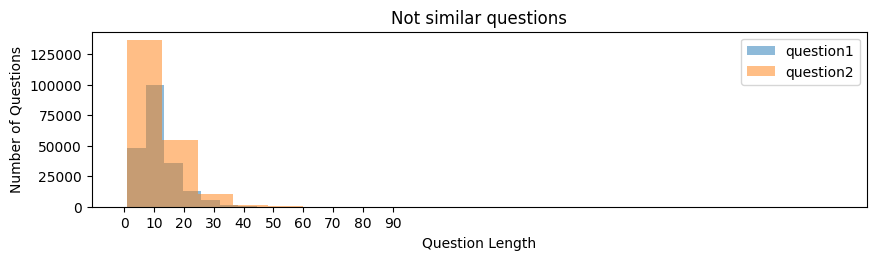

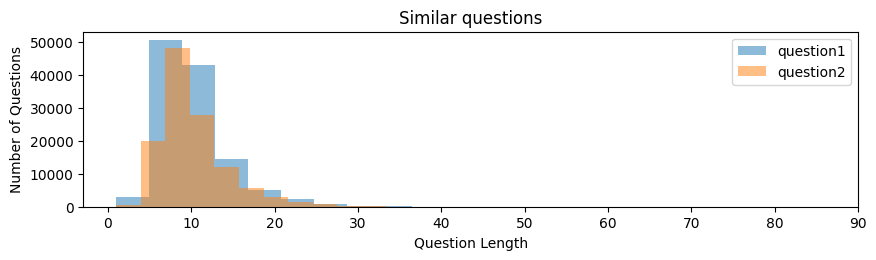

In [ ]:
plt.figure(figsize = (10, 5))
plt.subplot(2,1,1)
plt.hist(df_train[df_train['is_duplicate']==0]['q1_len'], bins = 20, alpha = 0.5, label = 'question1')
plt.hist(df_train[df_train['is_duplicate']==0]['q2_len'], bins = 20, alpha = 0.5, label = 'question2')
plt.xlabel('Question Length')
plt.ylabel('Number of Questions')
plt.title('Not similar questions')
plt.xticks(np.arange(0,100,10))
plt.legend()
plt.figure(figsize = (10, 5))

plt.subplot(2,1,1)
plt.hist(df_train[df_train['is_duplicate']==1]['q1_len'], bins = 20, alpha = 0.5, label = 'question1')
plt.hist(df_train[df_train['is_duplicate']==1]['q2_len'], bins = 20, alpha = 0.5, label = 'question2')
plt.xlabel('Question Length')
plt.ylabel('Number of Questions')
plt.title('Similar questions')
plt.xticks(np.arange(0,100,10))
plt.legend()

Based on the charts similar questions are mostly shorter (up to 20 words), but the number of words distributions are not that different

In [ ]:
print(f'Mean length for duplicate questions: q1:{df_train[df_train["is_duplicate"]==1]["q1_len"].mean()}, q2: {(df_train[df_train["is_duplicate"]==1]["q2_len"]).mean()}')
print(f'Mean length for not duplicate questions: q1:{df_train[df_train["is_duplicate"]==0]["q1_len"].mean()}, q2: {(df_train[df_train["is_duplicate"]==0]["q2_len"]).mean()}')

Mean length for duplicate questions: q1:9.847684448538649, q2: 9.855045641068587
Mean length for not duplicate questions: q1:11.582038927746925, q2: 11.96269955249266


Text(0.5, 1.0, 'Duplicate Questions')

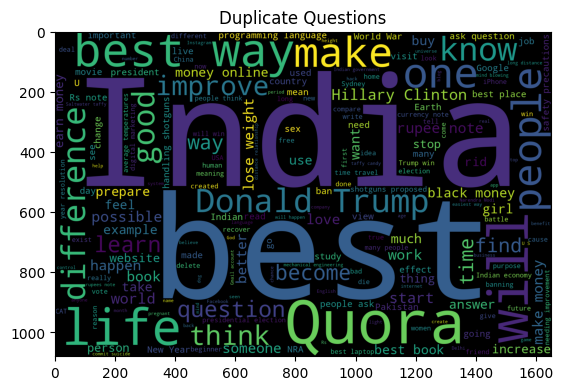

In [ ]:
from wordcloud import WordCloud
duplicate_questions = ''.join(df_train[df_train['is_duplicate'] == 1]['question1'])+' '+''.join(df_train[df_train['is_duplicate'] == 1]['question2'])
cloud_duplicate = WordCloud(width=1650, height=1080).generate(duplicate_questions)
plt.imshow(cloud_duplicate)
plt.title('Duplicate Questions')


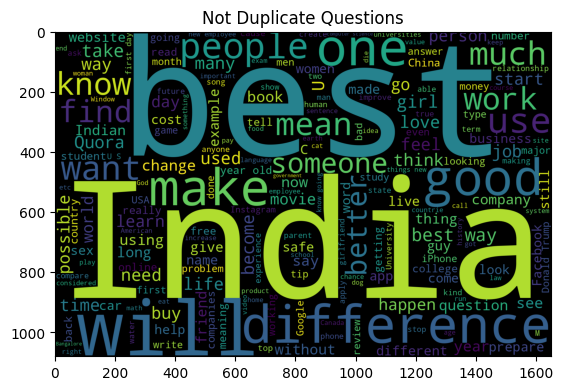

In [ ]:
not_duplicate_questions = ''.join(df_train[df_train['is_duplicate'] == 0]['question1'])+' '+''.join(df_train[df_train['is_duplicate'] == 0]['question2'])
cloud = WordCloud(width=1650, height=1080).generate(not_duplicate_questions)
plt.imshow(cloud)
plt.title('Not Duplicate Questions')
plt.show()

Both duplicated and not duplicated questions share the same commonly used words:
India, Life, Good, Best.
Duplicate questions have more occurancies with Donald Trump and Hilary Clonton word pairs. Also, 'quora' mentioned less frequently in not duplacted questions.

# Text Preprocessing

In [ ]:
from ast import mod
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
english_stopwords = stopwords.words('english')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
     morphy_tag = {'NN':'n', 'JJ':'a',
                   'VB':'v', 'RB':'r'}
     try:
         return morphy_tag[penntag[:2]]
     except:
         return 'n'

def clean_question(question):
    question = str(question).lower().strip()
    question = re.sub(r'[^a-z0-9\s]', '', question)
    question = re.sub(r'\s{2,}', ' ', question)
    words = word_tokenize(question)
    tagged_words = pos_tag(words)

    words = [wnl.lemmatize(word, penn2morphy(tag)) for word, tag in tagged_words if word not in english_stopwords]
    question = ' '.join(words)
    return question


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df_train['q1_preprocessed'] = df_train['question1'].apply(clean_question)
df_train['q2_preprocessed'] = df_train['question2'].apply(clean_question)

In [ ]:
df_test['q1_preprocessed'] = df_test['question1'].apply(clean_question)
df_test['q2_preprocessed'] = df_test['question2'].apply(clean_question)

In [ ]:
# With the cleaned questions create embeddings to use as an inputs for models
vectorizer_tfidf = TfidfVectorizer(ngram_range = (1,2),
                                   max_features=5000)
all_questions_train = (df_train['q1_preprocessed']) + (df_train['q2_preprocessed']).tolist()
all_questions_val = (df_test['q1_preprocessed']) + (df_test['q2_preprocessed']).tolist()
# We will split train dataset for train and test and use the test dataset from df_test as validatio
X_train_tfdf = vectorizer_tfidf.fit_transform(all_questions_train)
X_val_tfdf = vectorizer_tfidf.transform(all_questions_val)
y_train = df_train['is_duplicate']
y_val = df_test['is_duplicate']

In [ ]:
X_train_tfdf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2194401 stored elements and shape (323429, 5000)>

# Modeling

Firs we will run the baseline models for TF-IDF embeddings to see the result on the simple algorithms like Logistic regression and compare the results with XGBoost.

In [ ]:
from sre_constants import LITERAL_LOC_IGNORE
from sklearn.metrics import log_loss, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

x_train, x_test, y_train_tf, y_test_tf = train_test_split(X_train_tfdf,
                                                    y_train,
                                                    test_size = 0.2,
                                                    random_state = 42)

def predict_evaluate_model(model, X, y, name = ''):
  model.fit(X, y)

  y_pred = model.predict(X)
  y_pred_proba= model.predict_proba(X)



  print('{} dataset results'.format(name))
  f1 = f1_score(y, y_pred)
  print("F1 score: {:.2f}%".format(f1))
  log_loss_value = log_loss(y, y_pred_proba)
  print("Log loss: {:.2f}%".format(log_loss_value))
  print('Confusion matrix')
  cf = confusion_matrix(y, y_pred, normalize = 'true')
  cf_counts = confusion_matrix(y, y_pred)
  labels = (np.asarray(["{0}\n{1:.2f}".format(count, norm)
                      for count, norm in zip(cf_counts.flatten(), cf.flatten())])
          ).reshape(cf.shape)
  plt.figure()
  sns.heatmap(cf, annot = labels, cmap = 'Blues', fmt = '')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.title('{} Confusion Matrix'.format(name))
  plt.show()

In [ ]:
lr = LogisticRegression(solver = 'saga')
predict_evaluate_model(lr, x_train, y_train_tf, 'Train')
#Evaluate on test set
predict_evaluate_model(lr, x_test, y_test_tf, 'Test')
#Evaluate on test dataset - validation
predict_evaluate_model(lr, X_val_tfdf, y_val, 'Validation')

In [ ]:
xgb = XGBClassifier(booster = 'gblinear')
predict_evaluate_model(xgb, x_train, y_train_tf, 'Train')
#Evaluate on test set
predict_evaluate_model(xgb, x_test, y_test_tf, 'Test')
#Evaluate on test dataset - validation
predict_evaluate_model(xgb, X_val_tfdf, y_val, 'Validation')


Based on the results of the predictions XGBoost has better results with a bit higher F1: 0.64 and lower logloss: 0.51 for test data, but seems like there is an underfit for this model. Results for test and validation datasets are better than for the train set.

# Bert Embeddings

While TF-IDF is a simple and effective method, it has several fundamental limitations when it comes to capturing semantic similarity.

 BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model that can generate contextualized embeddings for words and sentences.
 Unlike traditional word embeddings (like Word2Vec or GloVe) that generate a single fixed embedding for each word, BERT produces contextualized embeddings. SentenseTransformer is a Python library built on top of BERT which is optimized for sentense embeddings and can capture semantic meaning well, which is good for comparing questions.


In [ ]:
pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 141.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import paired_cosine_distances
from sentence_transformers import SentenceTransformer, util

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_sentense = SentenceTransformer('all-MiniLM-L6-v2')

#in order to optimize memory isage we will use batching

def generate_embeddings(batch_size, text, model):
    """
    Generates sentence embeddings for a list of texts using the provided model.

    Args:
        batch_size (int): The batch size to use for encoding.
        texts (list): A list of strings (sentences) to encode.
        model (SentenceTransformer): The pre-trained SentenceTransformer model.

    Returns:
        torch.Tensor: A tensor containing the embeddings for the input texts.
    """
    embedding = model.encode(text,
                           conver_to_tensor = True,
                           batch_size = batch_size)
    return embedding


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_train[['q1_preprocessed', 'q2_preprocessed']],
                                                    df_train['is_duplicate'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [ ]:
# Generate BERT embeddings for the training and testing sets
batch_size = 32
question_1_bert_train = generate_embeddings(batch_size, X_train['q1_preprocessed'].tolist(), model_sentense)
question_2_bert_train = generate_embeddings(batch_size, X_train['q2_preprocessed'].tolist(), model_sentense)
question_1_bert_test = generate_embeddings(batch_size, X_test['q1_preprocessed'].tolist(), model_sentense)
question_2_bert_test = generate_embeddings(batch_size, X_test['q2_preprocessed'].tolist(), model_sentense)

In [ ]:
#Generating embeddings for validation set
question_1_bert_val = generate_embeddings(batch_size, df_test['q1_preprocessed'].tolist(), model_sentense)
question_2_bert_val = generate_embeddings(batch_size, df_test['q2_preprocessed'].tolist(), model_sentense)

To find out how similar are the questions we will use cosine similarity. It measures the similarity between two vectors by calculating the cosine of the angle between them.If the questions are very similar, their directions will be almost the same, and the result will be close to 1. If they're quite different, their directions will be nearly at a right angle (90 degrees), and the result will be close to 0.

In [ ]:
#since the training dataset is large it is better to conduct calculations in batches
def cosine_similarity_calc(question_1_embeddings, question_2_embeddings, batch_size=1024):
    """
    Calculates cosine similarity between corresponding pairs of question embeddings in batches.

    Args:
        question_1_embeddings (torch.Tensor): Embeddings for the first set of questions.
        question_2_embeddings (torch.Tensor): Embeddings for the second set of questions.
        batch_size (int): The batch size for similarity calculation.

    Returns:
        np.ndarray: An array of cosine similarity scores.
    """
    num_samples = question_1_embeddings.shape[0]
    cosine_scores = []

    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        # paired_cosine_distances returns 1 - cosine_similarity, so subtract from 1.
        batch_cosine = 1 - paired_cosine_distances(
            question_1_embeddings[batch_start:batch_end],
            question_2_embeddings[batch_start:batch_end]
        )
        cosine_scores.append(batch_cosine)

    return np.concatenate(cosine_scores)


In [ ]:
cosine_scores_train = cosine_similarity_calc(question_1_bert_train, question_2_bert_train,batch_size = 512 )
cosine_scores_test = cosine_similarity_calc(question_1_bert_test, question_2_bert_test,batch_size = 512 )
cosine_scores_val = cosine_similarity_calc(question_1_bert_val, question_2_bert_val,batch_size = 512 )

In order to classify two questions are duplicate or not we need to find a threshold for cosine similarity value at which the questions will be labeled as duplicates. Since the test dataset is the smallest we will use it to find the best parameter that will get us best F1-score

In [ ]:
thresholds = np.arange(0.3, 0.95, 0.05)
best_f1 = 0
best_threshold = 0

for threshold in thresholds:
  predicted = (cosine_scores_test>=threshold).astype(int)
  f1 = f1_score(y_test.values, predicted)

  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold
    print(f'Best threshold is {round(threshold,2)} and f1_score is {f1:.2f} ')

Best threshold is 0.3 and f1_score is 0.59 
Best threshold is 0.35 and f1_score is 0.60 
Best threshold is 0.4 and f1_score is 0.61 
Best threshold is 0.45 and f1_score is 0.62 
Best threshold is 0.5 and f1_score is 0.64 
Best threshold is 0.55 and f1_score is 0.66 
Best threshold is 0.6 and f1_score is 0.67 
Best threshold is 0.65 and f1_score is 0.68 
Best threshold is 0.7 and f1_score is 0.69 


So if the cosine similarity is over 0.7 the question pair will be marked as duplicated

In [ ]:
predicted_train = (cosine_scores_train>= best_threshold).astype(int)
predicted_test = (cosine_scores_test>= best_threshold).astype(int)
predicted_val = (cosine_scores_val>= best_threshold).astype(int)
print(f'F1-Score for train dataset:{f1_score(y_train, predicted_train):.2f}')
print(f'F1-Score for test dataset:{f1_score(y_test, predicted_test):.2f}')
print(f'F1-Score for validation dataset:{f1_score(y_val, predicted_val):.2f}')


F1-Score for train dataset:0.69
F1-Score for test dataset:0.69
F1-Score for validation dataset:0.69


Result is slightly better than with TF-IDF embeddings. Let's analyze some of the wrong predicted question pairs.

In [ ]:
df_test['predicted_cosine'] = predicted_val

In [ ]:
#False Positive
df_test[(df_test['is_duplicate']==0)&(df_test['predicted_cosine']==1)]

While the model managed to find sentense similarities it didn't get the context of the questions, so made some mistakes in prediction

# Bert Tuning

Another approach of using BERT is taking a pre-trained  Bert model and training it further on a current task by updating it's weights.

In [ ]:
!pip install transformers datasets evaluate torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from transformers import DataCollatorWithPadding
from datasets import Dataset

In [ ]:
model_path = "google-bert/bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_path)

id2label = {0: "not_duplicate", 1: "duplicate"}
label2id = {"not_duplicate": 0, "duplicate": 1}
model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                           num_labels=2,
                                                           id2label=id2label,
                                                           label2id=label2id)

for name, param in model.bert.named_parameters():
    if 'encoder.layer' in name:
        # Extract layer number more carefully
        parts = name.split('.')
        layer_idx = parts.index('layer') + 1
        if layer_idx < len(parts):
            try:
                layer_num = int(parts[layer_idx])
                if layer_num < 8:
                    param.requires_grad = False
            except ValueError:
                # Skip if can't parse layer number
                continue

for param in model.classifier.parameters():
    param.requires_grad = True

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Text Preparing

In [ ]:
def tokenize(questions):
  return tokenizer(questions['q1_preprocessed'], questions['q2_preprocessed'], padding = 'max_length',
                   truncation = True, max_length = 128 )

In [ ]:
dataset_train = Dataset.from_pandas(df_train[["q1_preprocessed", "q2_preprocessed", "is_duplicate"]])
dataset_test = Dataset.from_pandas(df_test[["q1_preprocessed", "q2_preprocessed", "is_duplicate"]])

In [ ]:
tokenized_train = dataset_train.map(tokenize, batched = True)
tokenized_test = dataset_test.map(tokenize, batched = True)
tokenized_train = tokenized_train.rename_column("is_duplicate", "labels")
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test = tokenized_test.rename_column("is_duplicate", "labels")
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/323429 [00:00<?, ? examples/s]

Map:   0%|          | 0/80858 [00:00<?, ? examples/s]

In [ ]:
tokenized_train = tokenized_train.train_test_split(test_size = 0.2)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")
roc_auc = evaluate.load("roc_auc")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    preds = probs.argmax(axis=1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "roc_auc": roc_auc.compute(prediction_scores=probs[:,1], references=labels)["roc_auc"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }


Training model

In [ ]:
# hyperparameters
lr = 1e-4
batch_size = 16
num_epochs = 4

training_args = TrainingArguments(
    output_dir="bert-phishing-classifier",
    learning_rate=lr,
    save_steps=500,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train["train"],
    eval_dataset=tokenized_train["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: m-smirrenstuff (m-smirrenstuff-0) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc,F1
1,0.438500,0.379039,0.828572,0.906370,0.783219
2,0.353000,0.369487,0.841712,0.917098,0.791751
3,0.304700,0.361697,0.841975,0.921846,0.803151
4,0.266800,0.372573,0.849256,0.924438,0.806846


TrainOutput(global_step=64688, training_loss=0.340765489554187, metrics={'train_runtime': 4985.0882, 'train_samples_per_second': 207.614, 'train_steps_per_second': 12.976, 'total_flos': 6.807814379701248e+16, 'train_loss': 0.340765489554187, 'epoch': 4.0})

In [ ]:
predictions = trainer.predict(tokenized_test)

In [ ]:
predictions.metrics

{'test_loss': 0.3613056540489197,
 'test_accuracy': 0.8415988523089861,
 'test_roc_auc': 0.9228747067210386,
 'test_f1': 0.8031476699864749,
 'test_runtime': 144.0761,
 'test_samples_per_second': 561.217,
 'test_steps_per_second': 35.079}

# Results

Results from the tuned Bert model are significantly better than the ones received from:
* XGBoost: F1 = 0.64
* BERT SentenceTransformer and cosine similarity: F1 = 0.69
* **BERT Fine Tuning: F1= 0.8**